# Python Modelling

## EDA and Drop Fitur Leakage

In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import warnings

warnings.filterwarnings("ignore")

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

### Load dataset

In [27]:
df = pd.read_csv("../data/credit_scoring.csv")
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


### EDA

In [28]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [29]:
# Statistik data
df.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


In [30]:
# Dataset shape
df.shape

(6000, 9)

In [31]:
# Cek missing values
df.isna().sum()

application_id       0
age                  0
monthly_income       0
loan_amount          0
previous_defaults    0
credit_score         0
default              0
leak_col_good        0
leak_col_subtle      0
dtype: int64

In [32]:
# Cek data duplikat
print("Jumlah data duplikat : ", df.duplicated().sum())

Jumlah data duplikat :  0


In [33]:
# Drop data leakage
leakage_cols = ["leak_col_good", "leak_col_subtle"]
df_new = df.drop(columns=leakage_cols)

In [34]:
df_new.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,501000,41,13995609,5982664,0,624,0
1,501001,58,13683833,3711198,0,809,0
2,501002,33,9417391,7172332,0,647,0
3,501003,45,6861811,8661056,0,450,0
4,501004,22,5640742,4520669,1,816,0


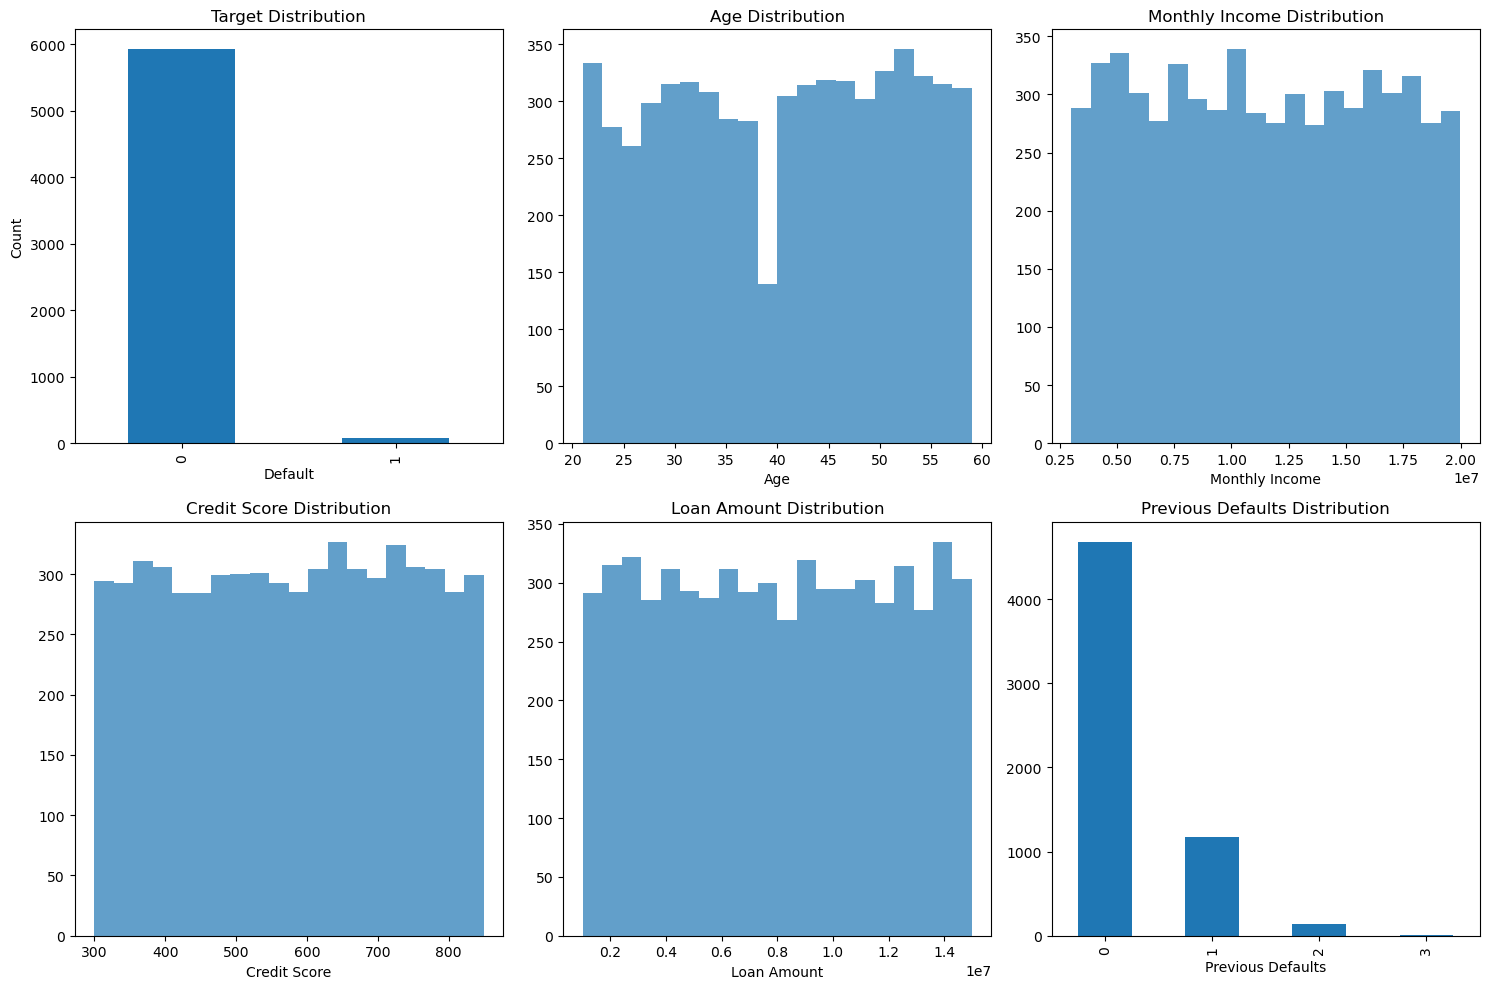

In [ ]:
# Distribusi Dataset
plt.figure(figsize=(15, 10))

# Target distribution
plt.subplot(2, 3, 1)
df["default"].value_counts().plot(kind="bar")
plt.title("Target Distribution")
plt.xlabel("Default")
plt.ylabel("Count")

# Age distribution
plt.subplot(2, 3, 2)
plt.hist(df["age"], bins=20, alpha=0.7)
plt.title("Age Distribution")
plt.xlabel("Age")

# Monthly income distribution
plt.subplot(2, 3, 3)
plt.hist(df["monthly_income"], bins=20, alpha=0.7)
plt.title("Monthly Income Distribution")
plt.xlabel("Monthly Income")

# Credit score distribution
plt.subplot(2, 3, 4)
plt.hist(df["credit_score"], bins=20, alpha=0.7)
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")

# Loan amount distribution
plt.subplot(2, 3, 5)
plt.hist(df["loan_amount"], bins=20, alpha=0.7)
plt.title("Loan Amount Distribution")
plt.xlabel("Loan Amount")

# Previous defaults
plt.subplot(2, 3, 6)
df["previous_defaults"].value_counts().plot(kind="bar")
plt.title("Previous Defaults Distribution")
plt.xlabel("Previous Defaults")

plt.tight_layout()
plt.show()

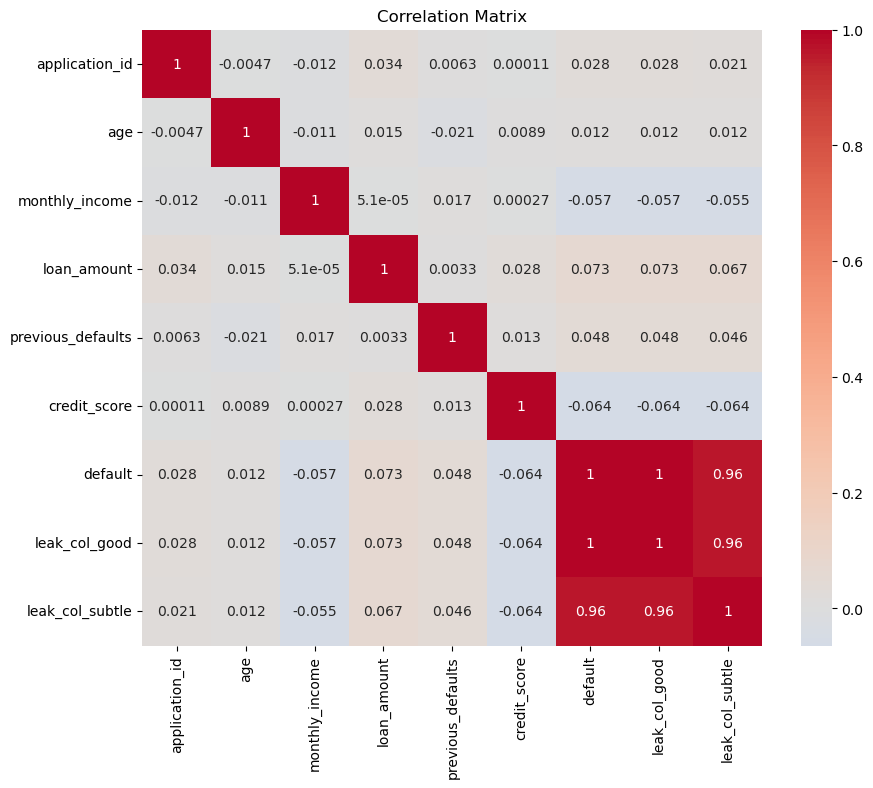

In [47]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.show()

## Baseline Logistic Reg -> GradientBoosting 

In [37]:
# Split dataset
X = df_new.drop(columns=["application_id", "default"])
y = df_new["default"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% data untuk test
    stratify=y,  
    random_state=42
)

In [38]:
print("Jumlah data pada data training:", X_train.shape[0])
print("Jumlah data pada data testing:", X_test.shape[0])

Jumlah data pada data training: 4800
Jumlah data pada data testing: 1200


In [40]:
# Data train
X_train.head()

,age,monthly_income,loan_amount,previous_defaults,credit_score
382,49,15929405,7257297,0,537
2603,50,13636274,6963137,0,610
65,48,3094579,1847424,0,356
3332,22,6156666,9324793,0,406
833,47,9886549,9609103,0,347


In [41]:
# Scaling dataset menggunakan standar scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression


In [44]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
lr_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]
lr_pred_label = lr.predict(X_test_scaled)

# Evaluasi
auc = roc_auc_score(y_test, lr_pred_proba)
accuracy = accuracy_score(y_test, lr_pred_label)

print("Logistic Regression AUC:", auc)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression AUC: 0.7552180028129395
Logistic Regression Accuracy: 0.9875


### Gradient Boosting

In [45]:
# Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, y_train)
gb_pred_proba = gb.predict_proba(X_test_scaled)[:, 1]
gb_pred_label = gb.predict(X_test_scaled)

# Evaluasi
auc = roc_auc_score(y_test, gb_pred_proba)
accuracy = accuracy_score(y_test, gb_pred_label)

print("Logistic Regression AUC:", auc)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression AUC: 0.6863009845288326
Logistic Regression Accuracy: 0.9858333333333333


In [ ]:
def scorecard(prob, min_score=300, max_score=850):
    # Inverse relationship: probabilitas lebih tinggi = skor lebih rendah
    # Gunakan transformasi log-odds untuk distribusi yang lebih baik
    odds = prob / (1 - prob + 1e-8) 
    log_odds = np.log(odds + 1e-8)

    # # Normalisasi ke kisaran 0-1 (kisaran perkiraan untuk log odds)
    # Kisaran log odds yang umum adalah sekitar -5 hingga 5
    normalized = (log_odds + 5) / 10
    normalized = np.clip(normalized, 0, 1)  # Ensure bounds

    # Ubah ke credit score scale (inverse relationship)
    score = max_score - (normalized * (max_score - min_score))

    return np.round(score).astype(int)

In [59]:
print("Scorecard Function Test:")
test_probs = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
for prob in test_probs:
    score = scorecard(prob)
    print(f"Probability: {prob:.2f} -> Credit Score: {score}")

Scorecard Function Test:
Probability: 0.01 -> Credit Score: 828
Probability: 0.05 -> Credit Score: 737
Probability: 0.10 -> Credit Score: 696
Probability: 0.20 -> Credit Score: 651
Probability: 0.30 -> Credit Score: 622
Probability: 0.50 -> Credit Score: 575
Probability: 0.70 -> Credit Score: 528
Probability: 0.90 -> Credit Score: 454


In [58]:
print(f"\n=== SCORECARD APPLICATION ===")
# Use the better model (Gradient Boosting)
credit_scores = scorecard(gb_pred_proba)

print("Credit Score Distribution:")
print(f"Min: {credit_scores.min()}")
print(f"Max: {credit_scores.max()}")
print(f"Mean: {credit_scores.mean():.1f}")
print(f"Median: {np.median(credit_scores):.1f}")


=== SCORECARD APPLICATION ===
Credit Score Distribution:
Min: 300
Max: 850
Mean: 841.0
Median: 850.0


## Shap top 10 fitur

In [61]:
import shap
# Buat SHAP explainer untuk model Gradient Boosting
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test)

In [62]:
# Feature importance
feature_importance = np.abs(shap_values).mean(0)
feature_names = X.columns

In [66]:
# Dapatkan fitur terbaik
top_10_idx = np.argsort(feature_importance)[-10:]
top_10_features = feature_names[top_10_idx]
top_10_importance = feature_importance[top_10_idx]

print("Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(
    zip(top_10_features[::-1], top_10_importance[::-1])
):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")
print("SHAP plot saved as 'shap_top10_features.png'")

Top 10 Most Important Features:
 1. age: 1.0417
 2. loan_amount: 0.7158
 3. credit_score: 0.6379
 4. monthly_income: 0.4422
 5. previous_defaults: 0.0371
SHAP plot saved as 'shap_top10_features.png'
